# Carga Train y Test

In [12]:
import pandas as pd
# Cargar datos de entrenamiento y prueba
train_data = pd.read_excel("../phishing_train.xlsX")
test_data = pd.read_excel("../phishing_test.xlsx")

# Random Forest

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separar características (X) y etiquetas (y) en el conjunto de entrenamiento
X_train = train_data.drop(columns=['label'])  # Características de entrenamiento
y_train = train_data['label']  # Etiquetas de entrenamiento

# Convertir todas las columnas categóricas a cadenas (string)
X_train = X_train.astype({col: str for col in X_train.select_dtypes(include=['object', 'category']).columns})
test_data = test_data.astype({col: str for col in test_data.select_dtypes(include=['object', 'category']).columns})

# Identificar columnas categóricas
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Transformar columnas categóricas con One-Hot Encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # Mantener las columnas numéricas sin cambios
)

# Aplicar la transformación al conjunto de entrenamiento y prueba
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(test_data)

# Entrenar el modelo de Random Forest
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_transformed, y_train)

# Predecir probabilidades para los datos de prueba
y_proba_test = model.predict_proba(X_test_transformed)[:, 1]

# Crear un DataFrame con las columnas 'Id' y 'Probability'
submission = pd.DataFrame({
    'Id': test_data['Id'],  # Asegurarse de que la columna 'Id' está presente en test_data
    'Probability': y_proba_test
})

# Guardar el archivo de envío en formato CSV
submission.to_csv("RFsubmission.csv", index=False)

print("Archivo de envío generado: 'submission.csv'")


Archivo de envío generado: 'submission.csv'


In [16]:
from sklearn.tree import export_text

# Obtener los nombres de las características transformadas por OneHotEncoder
onehot_features = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_columns)
transformed_feature_names = list(onehot_features) + list(X_train.select_dtypes(exclude=['object']).columns)

# Acceder a un árbol específico dentro del Random Forest
tree = model.estimators_[0]  # Cambia el índice para seleccionar otro árbol

# Mostrar los hiperparámetros básicos del árbol
print(f"Profundidad del árbol: {tree.get_depth()}")
print(f"Número de nodos terminales (hojas): {tree.get_n_leaves()}")

# Mostrar la estructura del árbol
tree_structure = export_text(tree, feature_names=transformed_feature_names)
print(tree_structure)


Profundidad del árbol: 32
Número de nodos terminales (hojas): 636
|--- TLDLegitimateProb <= 0.00
|   |--- TLD_si <= 0.50
|   |   |--- NoOfExternalRef <= 5.50
|   |   |   |--- TLD_hk <= 0.50
|   |   |   |   |--- DegitRatioInURL <= 0.00
|   |   |   |   |   |--- HasFavicon <= 0.50
|   |   |   |   |   |   |--- HasDescription <= 0.50
|   |   |   |   |   |   |   |--- NoOfImage <= 24.00
|   |   |   |   |   |   |   |   |--- HasSocialNet <= 0.50
|   |   |   |   |   |   |   |   |   |--- TLD_today <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- TLD_to <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- TLD_to >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- TLD_today >  0.50
|   |   |   |   |   |   |   |   |   |   |--- URLCharProb <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |   |-

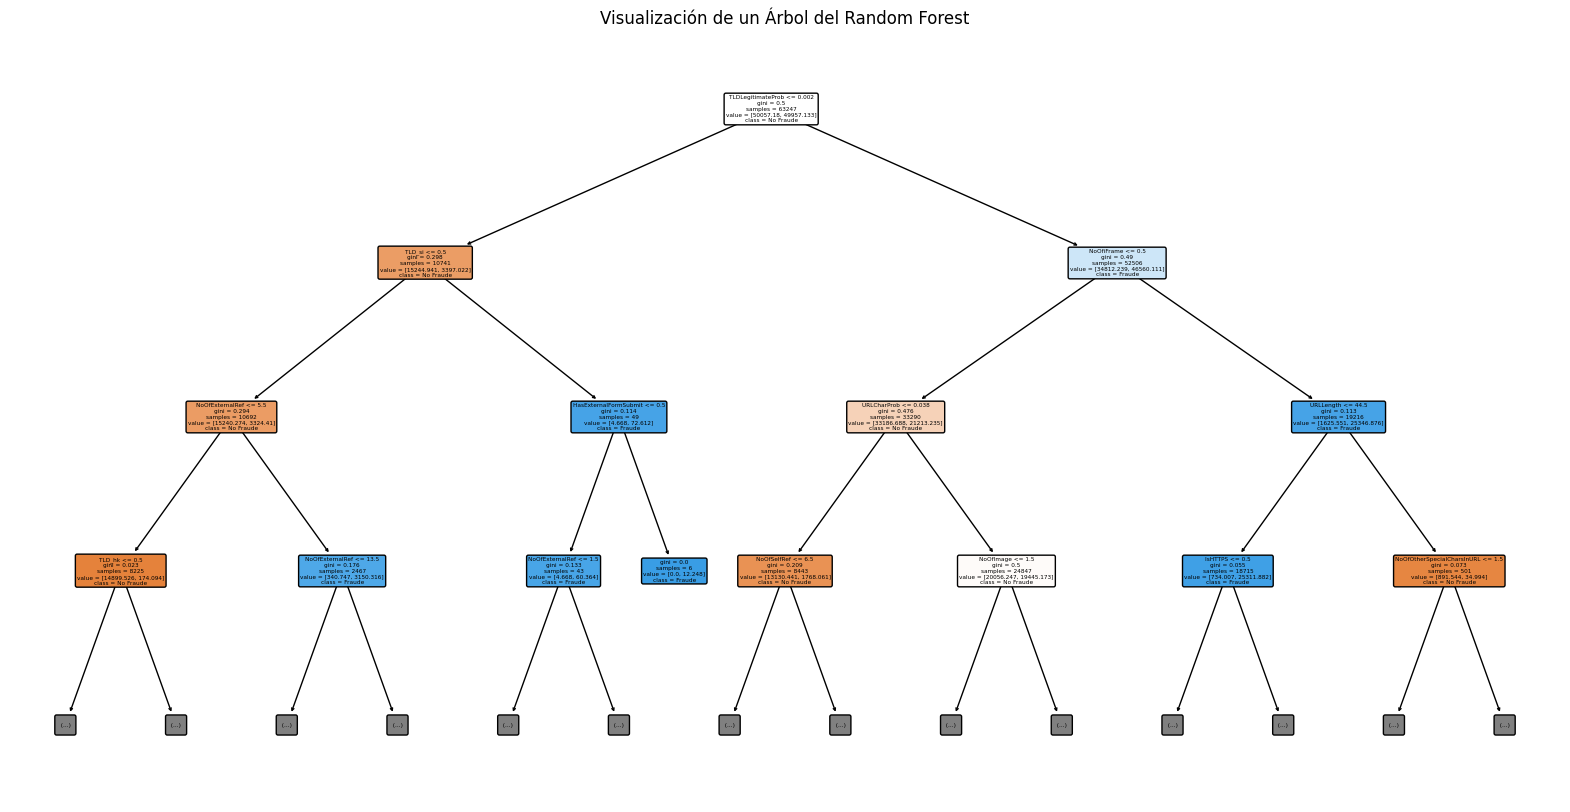

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Seleccionar uno de los árboles del modelo Random Forest
tree = model.estimators_[0]  # Cambia el índice para otro árbol

# Graficar el árbol
plt.figure(figsize=(20, 10))  # Ajusta el tamaño según sea necesario
plot_tree(tree, 
          feature_names=transformed_feature_names,  # Nombres de las características después del OneHotEncoding
          class_names=["No Fraude", "Fraude"],  # Etiquetas de clase
          filled=True,  # Colores para nodos según la clase predominante
          rounded=True,  # Esquinas redondeadas
          max_depth=3)  # Limitar la profundidad para que sea interpretable
plt.title("Visualización de un Árbol del Random Forest")
plt.show()


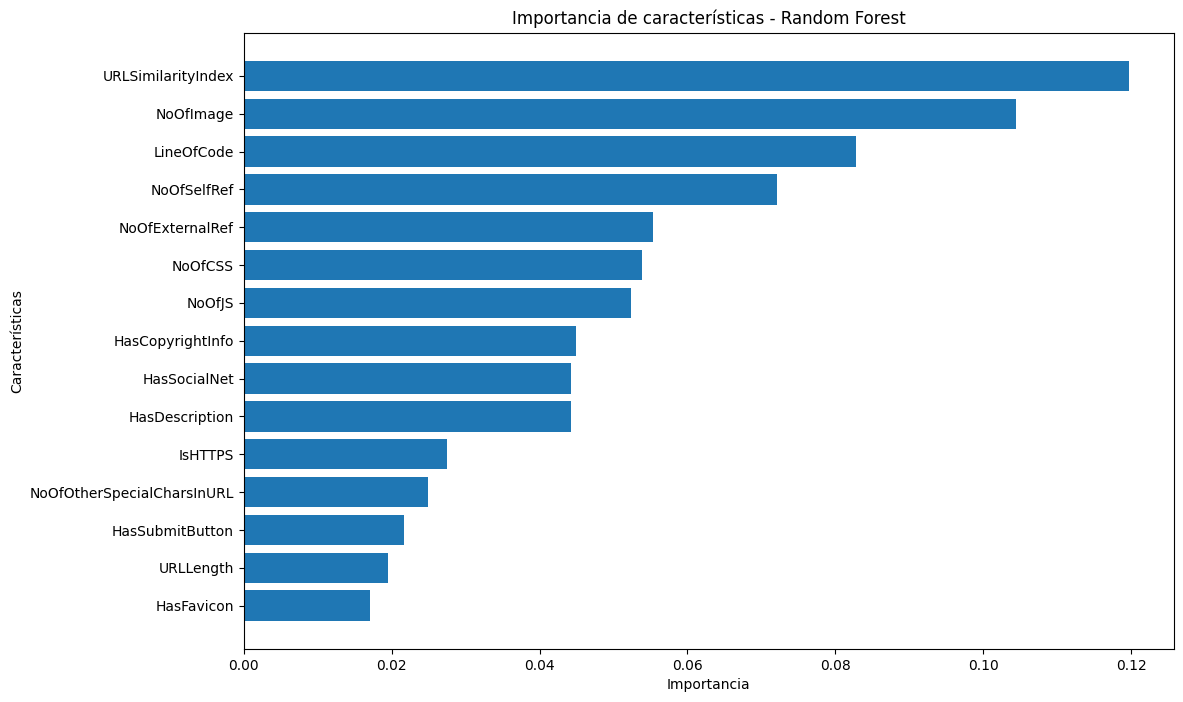

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la importancia de características
feature_importances = model.feature_importances_

# Obtener nombres de características
transformed_feature_names = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + list(X_train.drop(columns=categorical_columns).columns)

# Ordenar características por importancia
sorted_indices = np.argsort(feature_importances)[::-1]

# Graficar la importancia de características
plt.figure(figsize=(12, 8))
plt.barh(
    [transformed_feature_names[i] for i in sorted_indices[:15]],  # 15 características más relevantes
    feature_importances[sorted_indices[:15]]
)
plt.title("Importancia de características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.gca().invert_yaxis()
plt.show()


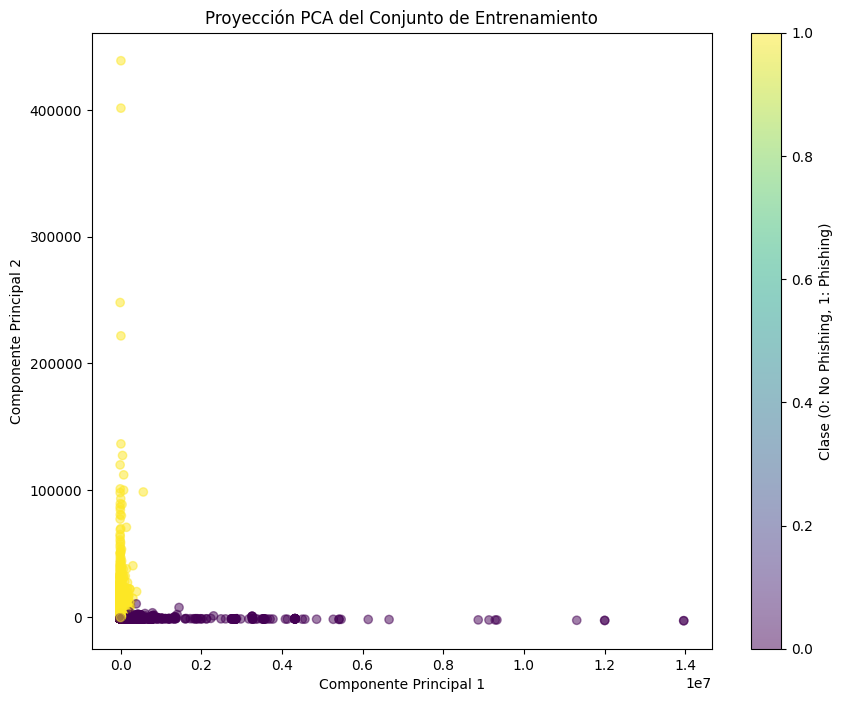

In [19]:
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_transformed.toarray())  # Convertir a array denso si es sparse

# Colorear según las etiquetas
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title("Proyección PCA del Conjunto de Entrenamiento")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Clase (0: No Phishing, 1: Phishing)")
plt.show()


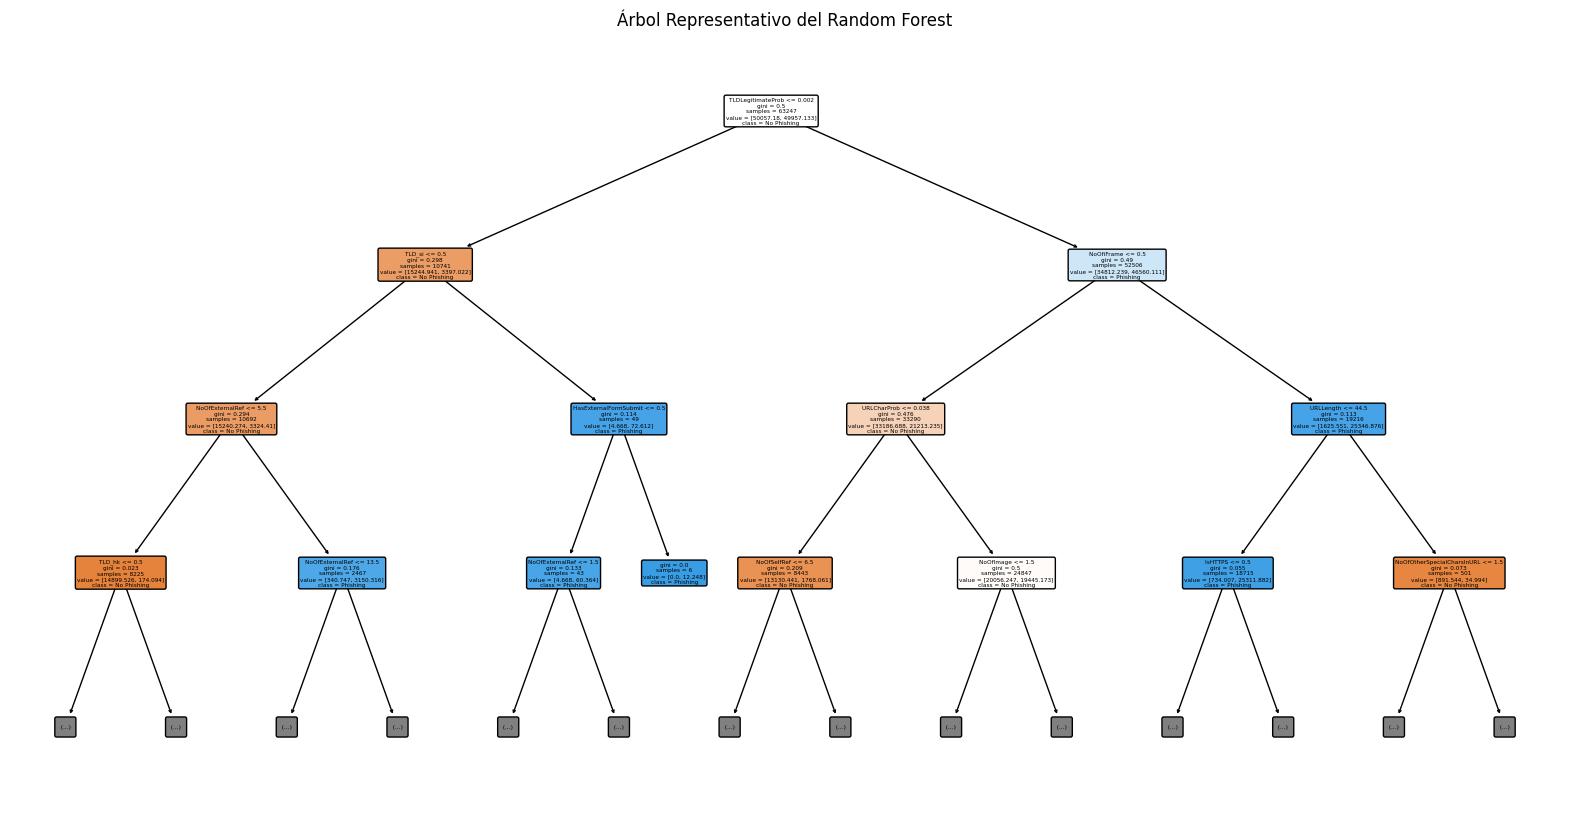

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Graficar un árbol representativo
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], 
          feature_names=transformed_feature_names, 
          class_names=["No Phishing", "Phishing"], 
          filled=True, 
          rounded=True, 
          max_depth=3)  # Limitar la profundidad
plt.title("Árbol Representativo del Random Forest")
plt.show()


Accuracy: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42847
           1       1.00      1.00      1.00     57153

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000


Confusion Matrix:
[[42847     0]
 [    0 57153]]


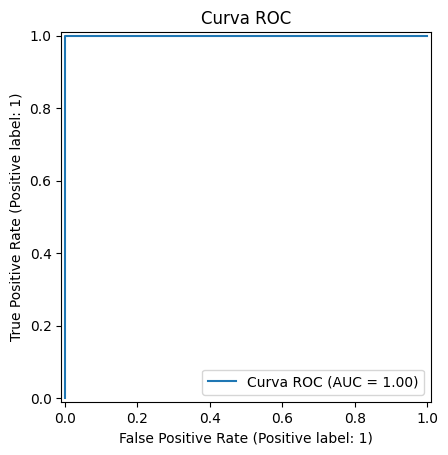

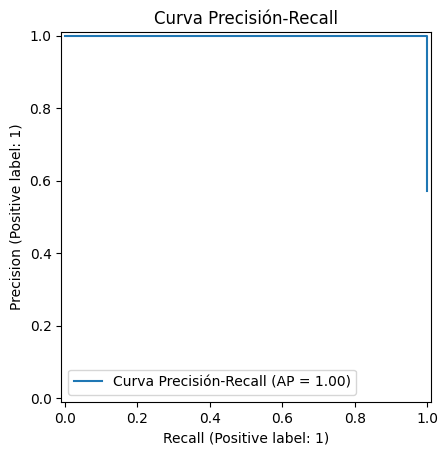

In [26]:
# Importar las librerías necesarias
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Predecir etiquetas y probabilidades en el conjunto de entrenamiento
y_train_pred = model.predict(X_train_transformed)
y_train_proba = model.predict_proba(X_train_transformed)[:, 1]

# Calcular métricas en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
auc_score_train = roc_auc_score(y_train, y_train_proba)

# Mostrar las métricas principales
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_score_train:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Graficar la curva ROC
roc_display = RocCurveDisplay.from_estimator(
    model, 
    X_train_transformed, 
    y_train, 
    name="Curva ROC"
)
plt.title("Curva ROC")
plt.show()

# Graficar la curva de precisión-recall
pr_display = PrecisionRecallDisplay.from_estimator(
    model, 
    X_train_transformed, 
    y_train, 
    name="Curva Precisión-Recall"
)
plt.title("Curva Precisión-Recall")
plt.show()


# Gradient Boosting